<a href="https://colab.research.google.com/github/Igor-C-Assuncao/MVP_Series_temporais_NN/blob/main/MVP_IGOR_ASSUNCAO_PUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP: *Machine Learning & Analytics* — Manutenção Preditiva com Microsoft Azure Dataset


**Autor:** Igor Cassimiro Assunção 

**Data:** 26/09/2025


**Matrícula:** 4052025001927

**Dataset:** [Microsoft Azure Predictive Maintenance](https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance)

## ✅ Checklist do MVP 
- [x] **Problema definido** e contexto de negócio
- [x] **Carga e preparação** dos dados (sem vazamento de dados)
- [x] **Divisão** em treino/validação/teste (ou validação cruzada apropriada)
- [x] **Tratamento**: limpeza, transformação e **engenharia de atributos**
- [x] **Modelagem**: comparar abordagens/modelos (com **baseline**)
- [x] **Otimização de hiperparâmetros**
- [x] **Avaliação** com **métricas adequadas** e discussão de limitações
- [x] **Boas práticas**: seeds fixas, tempo de treino, recursos computacionais, documentação
- [x] **Pipelines reprodutíveis** (sempre que possível)

## 1. Escopo, objetivo e definição do problema

A manutenção de equipamentos é uma tarefa crítica e desafiadora em plantas industriais. Falhas não previstas podem interromper toda a cadeia produtiva, gerando prejuízos financeiros significativos, atrasos na entrega e riscos à segurança. Para mitigar esses problemas, a abordagem de Manutenção Preditiva (PdM), suportada por sensores IoT (Internet das Coisas), tem ganhado força. Estes sensores monitoram continuamente características operacionais das máquinas, como voltagem, rotação, pressão e vibração, gerando um alto volume de dados.

O objetivo deste projeto é desenvolver um modelo de Machine Learning capaz de analisar esses dados de telemetria para prever falhas em componentes de máquinas antes que elas ocorram, permitindo que a equipe de manutenção atue de forma proativa.

A tarefa a ser resolvida é uma **Classificação Binária Supervisionada em um contexto de Séries Temporais multivariadas**. O modelo será treinado com dados históricos rotulados para aprender a distinguir entre duas classes:

* **Classe 0:** Operação normal (Não Falha).
* **Classe 1:** Falha iminente (Falha).

### Área de Aplicação

Este projeto se insere nas áreas de:
* Manutenção Preditiva (Predictive Maintenance)
* Indústria 4.0
* Análise de Séries Temporais
* IIoT (Industrial Internet of Things)

### Valor para o Negócio

Um modelo de classificação de falhas bem-sucedido gera valor direto para o negócio de várias formas:

* **Redução de Downtime Não Planejado:** Evita paradas súbitas na produção, que são extremamente custosas.
* **Transição para Manutenção Proativa:** Permite que a equipe de manutenção passe de um modelo reativo ("consertar quando quebra") para um preditivo ("consertar antes de quebrar").
* **Otimização de Recursos:** Reduz custos com reparos de emergência e otimiza o agendamento da equipe de manutenção e o estoque de peças de reposição.
* **Aumento da Segurança:** Prever falhas pode evitar acidentes operacionais causados por componentes defeituosos.

## 2. Reprodutibilidade e ambiente
Para garantir a reprodutibilidade deste projeto, todas as etapas que envolvem aleatoriedade foram controladas por meio de uma (`seed`) fixa. Isso assegura que a divisão dos dados e a inicialização dos modelos sejam sempre as mesmas a cada execução, gerando resultados consistentes.

O ambiente computacional utilizado foi o Google Colab. As principais bibliotecas e suas respectivas versões estão documentadas na célula de código a seguir.

* **Linguagem:** Python
* **Bibliotecas Principais:**
    * `pandas` para manipulação de dados.
    * `numpy` para operações numéricas.
    * `scikit-learn` para o pipeline de pré-processamento, modelagem e avaliação.
    * `lightgbm` para a implementação do modelo de Gradient Boosting.
    * `matplotlib` e `seaborn` para a visualização de dados.
* **Semente Global (SEED):** O valor `47` foi utilizado em todo o projeto.

In [2]:
# === Setup básico e reprodutibilidade ===
import os, random, time, sys, math
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    classification_report, ConfusionMatrixDisplay
)
from lightgbm import LGBMClassifier
import joblib

SEED = 47
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 47


### 2.1 Funções python (opcional)
Defina, se necessário, funções em Python para reutilizar seu código e torná-lo mais organizado. Essa é uma boa prática de programação que facilita a leitura, manutenção e evolução do seu projeto.

## 3. Dados: carga, entendimento e qualidade

O conjunto de dados utilizado é o **Microsoft Azure Predictive Maintenance**, que simula dados de telemetria e eventos de uma frota de 100 máquinas ao longo de um ano.

O dataset é composto por 5 arquivos principais:
* **PdM_telemetry.csv**: Leituras horárias de sensores (voltagem, rotação, pressão, vibração).
* **PdM_errors.csv**: Registros de erros, com data, tipo e máquina associada.
* **PdM_maint.csv**: Registros de manutenções, com data, tipo de componente e máquina.
* **PdM_failures.csv**: Registros de falhas de componentes, com data e máquina.
* **PdM_machines.csv**: Metadados das máquinas (modelo e idade).

### Dicionário de Variáveis (Após Engenharia de Atributos)

As features utilizadas no modelo foram construídas a partir da combinação e agregação dos dados brutos:

* `volt`, `rotate`, `pressure`, `vibration`: Leituras instantâneas dos sensores.
* `age`: Idade da máquina em anos.
* `model`: Modelo da máquina (categórico).
* `volt_mean_24h`, `rotate_mean_24h`, etc.: Média móvel das leituras dos sensores nas últimas 24 horas.
* `volt_std_24h`, `rotate_std_24h`, etc.: Desvio padrão móvel das leituras dos sensores nas últimas 24 horas.
* `error_count_24h`: Número de erros registrados nas últimas 24 horas.
* `maint_count_24h`: Número de manutenções realizadas nas últimas 24 horas.
* `failure` (Alvo): Variável binária indicando uma falha iminente nas próximas 24 horas.

### Prevenção de Vazamento de Dados (Data Leakage)

**Divisão Prévia**: O conjunto de dados foi dividido em treino e teste antes de qualquer etapa de pré-processamento. A divisão foi estratificada para manter a proporção de falhas.

**Uso de Pipelines**: Todas as etapas de transformação (`StandardScaler` e `OneHotEncoder`) foram encapsuladas em um `Pipeline` do Scikit-learn. Isso garante que as estatísticas (média, desvio padrão) para a normalização sejam aprendidas **apenas** com os dados de treino.

### 3.1 Carga e Preparação dos Dados

Foi ultilizado o kagglehub para o carregamento dos dados




In [3]:
!pip install kagglehub[pandas-datasets] pandas

In [4]:

import pandas as pd
from kagglehub import KaggleDatasetAdapter, load_dataset

DATASET = "arnabbiswas1/microsoft-azure-predictive-maintenance"

telemetry_df   = load_dataset(KaggleDatasetAdapter.PANDAS, DATASET, "PdM_telemetry.csv",
                           pandas_kwargs={"parse_dates": ["datetime"]})
errors_df      = load_dataset(KaggleDatasetAdapter.PANDAS, DATASET, "PdM_errors.csv",
                           pandas_kwargs={"parse_dates": ["datetime"]})
maint_df = load_dataset(KaggleDatasetAdapter.PANDAS, DATASET, "PdM_maint.csv",
                           pandas_kwargs={"parse_dates": ["datetime"]})
failures_df    = load_dataset(KaggleDatasetAdapter.PANDAS, DATASET, "PdM_failures.csv",
                           pandas_kwargs={"parse_dates": ["datetime"]})
machines_df   = load_dataset(KaggleDatasetAdapter.PANDAS, DATASET, "PdM_machines.csv")

print(telemetry_df.head(), errors_df.head(), maint_df.head(), failures_df.head(), machines_df.head(), sep="\n\n")



# Converter colunas de data para o formato datetime
for df in [telemetry_df, errors_df, maint_df, failures_df]:
    df['datetime'] = pd.to_datetime(df['datetime'])

print("--- Informações Básicas dos Datasets ---")
print("Telemetria:")
telemetry_df.info()
print("\nPrimeiras 5 linhas de Telemetria:")
display(telemetry_df.head())

/tmp/ipython-input-3196032246.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  telemetry_df   = load_dataset(KaggleDatasetAdapter.PANDAS, DATASET, "PdM_telemetry.csv",


100%|██████████| 31.0M/31.0M [00:00<00:00, 87.2MB/s]

Extracting zip of PdM_telemetry.csv...



/tmp/ipython-input-3196032246.py:8: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  errors_df      = load_dataset(KaggleDatasetAdapter.PANDAS, DATASET, "PdM_errors.csv",


Using Colab cache for faster access to the 'microsoft-azure-predictive-maintenance' dataset.


/tmp/ipython-input-3196032246.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  maint_df = load_dataset(KaggleDatasetAdapter.PANDAS, DATASET, "PdM_maint.csv",


Using Colab cache for faster access to the 'microsoft-azure-predictive-maintenance' dataset.


/tmp/ipython-input-3196032246.py:12: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  failures_df    = load_dataset(KaggleDatasetAdapter.PANDAS, DATASET, "PdM_failures.csv",


Using Colab cache for faster access to the 'microsoft-azure-predictive-maintenance' dataset.


/tmp/ipython-input-3196032246.py:14: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  machines_df   = load_dataset(KaggleDatasetAdapter.PANDAS, DATASET, "PdM_machines.csv")


Using Colab cache for faster access to the 'microsoft-azure-predictive-maintenance' dataset.
             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511  

             datetime  machineID errorID
0 2015-01-03 07:00:00          1  error1
1 2015-01-03 20:00:00          1  error3
2 2015-01-04 06:00:00          1  error5
3 2015-01-10 15:00:00          1  error4
4 2015-01-22 10:00:00          1  error4

             datetime  machineID   comp
0 2014-06-01 06:00:00          1  comp2
1 2014-07-16 06:00:00          1  comp4
2 2014-07-31 06:

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


## 3.2 Engenharia de Atributos


### Atributos de Janela Temporal (Rolling Features)
Para capturar as tendências e a estabilidade recentes das operações da máquina, foram criadas features de janela temporal a partir dos dados brutos dos sensores (volt, rotate, pressure, vibration).

Entaão para cada máquina, foram calculadas as médias móveis e os desvios padrão móveis sobre uma janela de 24 horas.

Assim em vez de usar uma leitura instantânea, que pode ser ruidosa, a média móvel (_mean_24h) fornece uma visão mais estável do comportamento recente do sensor. O desvio padrão móvel (_std_24h) mede a volatilidade ou instabilidade do sensor no mesmo período, sendo um forte indicador de comportamento anômalo.

### Atributos de Eventos (Erros e Manutenções)

Para incorporar o histórico de eventos de cada máquina, os dados de erros e manutenções foram integrados ao dataset de telemetria.

* Foi utilizada a função pd.merge_asofn ela realiza uma junção temporal "para trás". Para cada registro de telemetria em um tempo t, ela busca o erro ou manutenção mais recente que ocorreu em ou antes de t para aquela máquina. Isso simula perfeitamente um cenário real, onde o sistema só tem conhecimento de eventos passados, evitando qualquer vazamento de dados do futuro.

### Criação da Variável Alvo (failure_imminent)

A definição da variável alvo é o que enquadra nosso problema de negócio. Em vez de prever o momento exato da falha, criamos um alvo que representa uma janela de alerta.

        Foi criada uma coluna binária chamada failure_imminent. Para cada falha real registrada, todos os registros de telemetria daquela máquina nas 24 horas anteriores ao evento foram rotulados como 1 (Falha Iminente). Todos os outros registros foram rotulados como 0.

* Esta abordagem transforma o problema em uma tarefa de classificação muito mais útil na prática: "Com base nos dados das últimas 24 horas, a máquina irá falhar nas próximas 24 horas?". Isso fornece uma janela de tempo acionável para que a equipe de manutenção possa intervir.

Ao final deste processo, obtemos um único DataFrame final, onde cada linha representa uma hora de operação de uma máquina, enriquecida com seu histórico recente de sensores e eventos, e com um rótulo claro indicando o risco de falha iminente.

In [5]:
# Engenharia de Atributos Temporais (rolling features)
print("Criando features de média e desvio padrão em janela de 24h...")
temp_df = []
for machine_id in telemetry_df['machineID'].unique():
    machine_subset = telemetry_df[telemetry_df['machineID'] == machine_id].copy()
    machine_subset.set_index('datetime', inplace=True)

    # Médias móveis
    rolling_mean = machine_subset[['volt', 'rotate', 'pressure', 'vibration']].rolling(window='24h').mean()
    machine_subset['volt_mean_24h'] = rolling_mean['volt']
    machine_subset['rotate_mean_24h'] = rolling_mean['rotate']
    machine_subset['pressure_mean_24h'] = rolling_mean['pressure']
    machine_subset['vibration_mean_24h'] = rolling_mean['vibration']

    # Desvios padrão móveis
    rolling_std = machine_subset[['volt', 'rotate', 'pressure', 'vibration']].rolling(window='24h').std()
    machine_subset['volt_std_24h'] = rolling_std['volt']
    machine_subset['rotate_std_24h'] = rolling_std['rotate']
    machine_subset['pressure_std_24h'] = rolling_std['pressure']
    machine_subset['vibration_std_24h'] = rolling_std['vibration']

    temp_df.append(machine_subset.reset_index())

telemetry_feat_df = pd.concat(temp_df)
telemetry_feat_df.dropna(inplace=True) # Remove as primeiras 23 horas de cada máquina

# Contagem de erros e manutenções em janela de 24h
print("Criando features de contagem de eventos em janela de 24h...")
errors_df['error_count_24h'] = errors_df.groupby('machineID').cumcount()
maint_df['maint_count_24h'] = maint_df.groupby('machineID').cumcount()

# Unir todas as features em um único DataFrame
print("Unindo todos os dados...")
df_features = telemetry_feat_df.merge(machines_df, on='machineID', how='left')

# Para erros e manutenções, precisamos fazer um merge temporal
df_features = pd.merge_asof(df_features.sort_values('datetime'),
                              errors_df[['datetime', 'machineID', 'errorID']].sort_values('datetime'),
                              on='datetime', by='machineID', direction='backward')

df_features = pd.merge_asof(df_features.sort_values('datetime'),
                              maint_df[['datetime', 'machineID', 'comp']].sort_values('datetime'),
                              on='datetime', by='machineID', direction='backward')

# Criar a variável alvo (target)
print("Criando a variável alvo 'failure'...")
failures_df['failure'] = 1
df_final = df_features.merge(failures_df, on=['datetime', 'machineID'], how='left')
df_final['failure'].fillna(0, inplace=True)

# Rotular as 24h antes da falha como 1
failure_times = df_final[df_final['failure'] == 1][['datetime', 'machineID']]
df_final['failure_imminent'] = 0

for index, row in failure_times.iterrows():
    machine_id = row['machineID']
    failure_time = row['datetime']
    start_window = failure_time - pd.Timedelta(hours=24)

    mask = (
        (df_final['machineID'] == machine_id) &
        (df_final['datetime'] >= start_window) &
        (df_final['datetime'] <= failure_time)
    )
    df_final.loc[mask, 'failure_imminent'] = 1

df_final.drop(columns=['failure', 'errorID', 'comp'], inplace=True)

print("\nDataFrame final com features e alvo criado!")
display(df_final.head())

Criando features de média e desvio padrão em janela de 24h...
Criando features de contagem de eventos em janela de 24h...
Unindo todos os dados...
Criando a variável alvo 'failure'...


/tmp/ipython-input-788906735.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['failure'].fillna(0, inplace=True)



DataFrame final com features e alvo criado!


,datetime,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_std_24h,rotate_std_24h,pressure_std_24h,vibration_std_24h,model,age,failure_imminent
0,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,169.548538,410.625784,104.269230,44.250829,9.431836,11.141591,12.457390,1.183494,model3,18,0
1,2015-01-01 07:00:00,15,153.765268,392.588977,104.408678,47.083505,155.765775,420.489365,101.572391,40.634629,2.829145,39.457108,4.011115,9.120089,model3,14,0
2,2015-01-01 07:00:00,76,184.895622,451.732037,93.720684,39.843708,181.474344,416.433103,101.957312,41.710205,4.838419,49.920232,11.648352,2.639625,model2,10,0
3,2015-01-01 07:00:00,19,183.336764,377.356276,101.731823,41.210684,178.652388,368.739906,99.749938,38.874248,6.624708,12.185386,2.802808,3.304220,model3,17,0
4,2015-01-01 07:00:00,77,197.546693,433.408151,92.121598,33.455576,188.782364,430.086823,94.533161,39.413938,12.394633,4.697066,3.410466,8.426396,model4,12,0


### 3.3 Análise exploratória resumida (EDA)




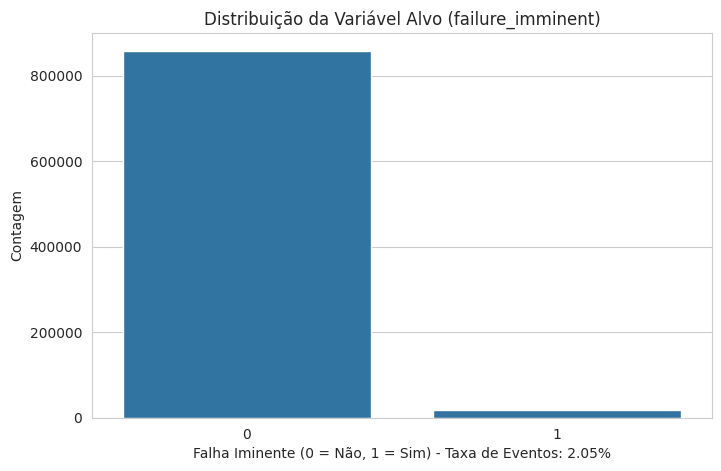


--- Análise de Distribuição das Features por Classe ---


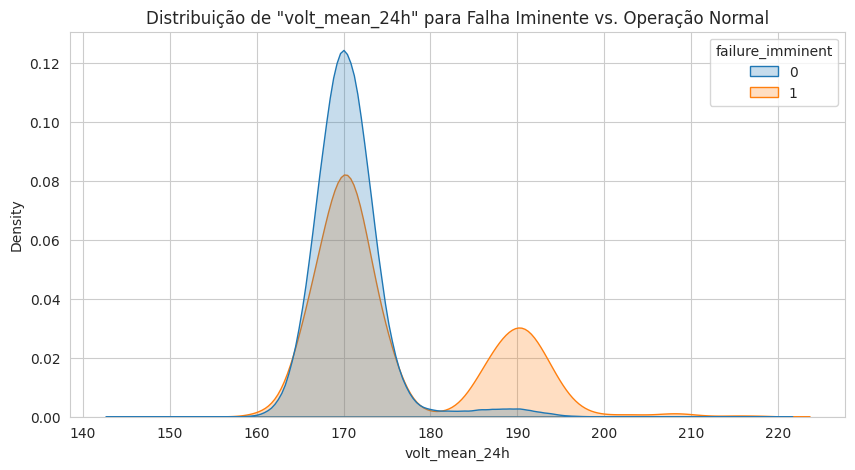

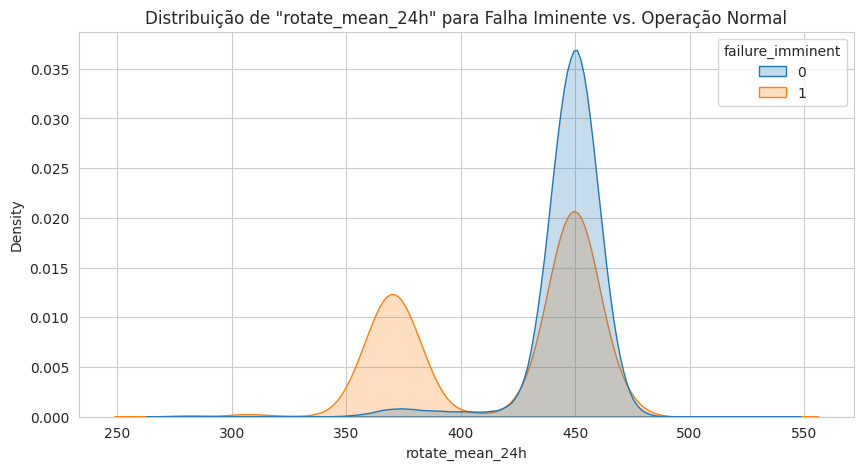

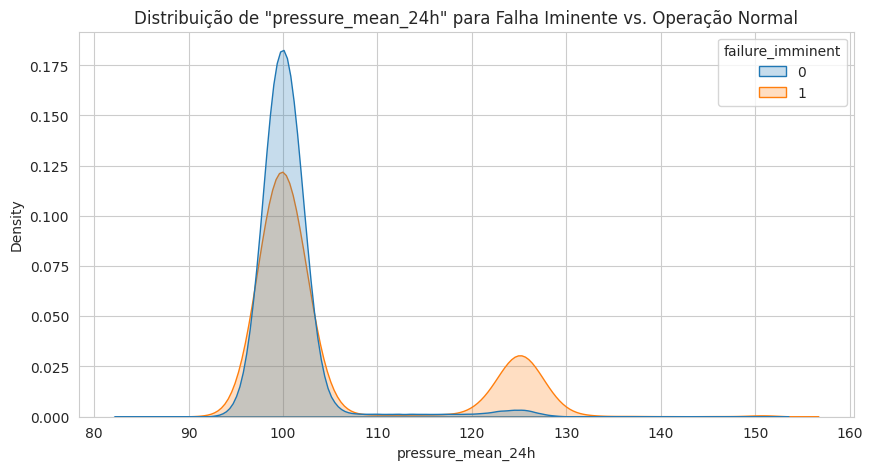

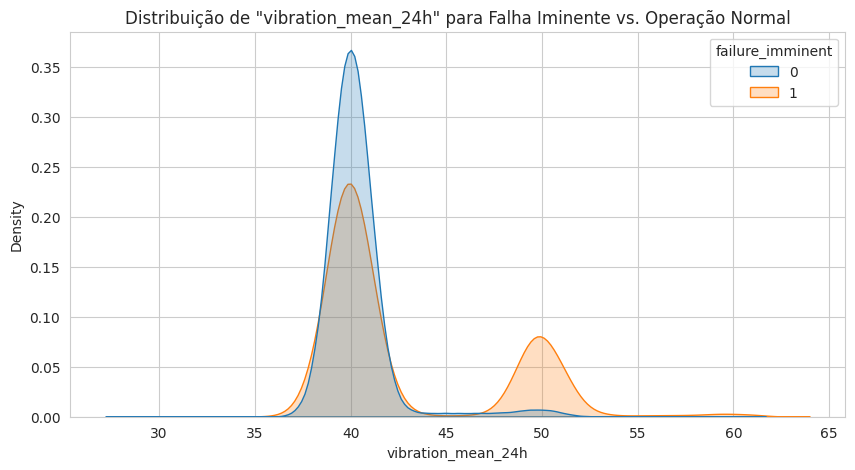

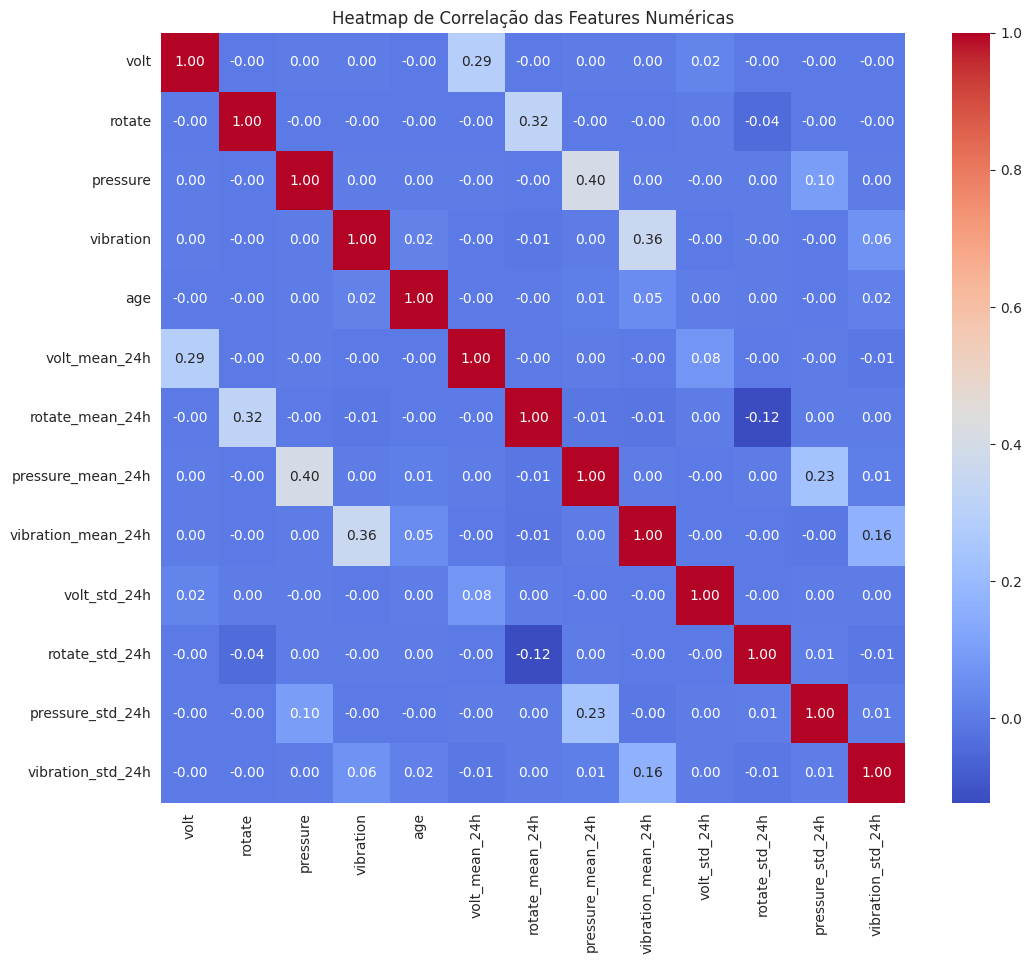

In [6]:
# 1. Visualizar o desbalanceamento da nova variável alvo
plt.figure(figsize=(8, 5))
sns.countplot(x='failure_imminent', data=df_final)
plt.title('Distribuição da Variável Alvo (failure_imminent)')
failure_rate = df_final['failure_imminent'].mean() * 100
plt.xlabel(f'Falha Iminente (0 = Não, 1 = Sim) - Taxa de Eventos: {failure_rate:.2f}%')
plt.ylabel('Contagem')
plt.show()

# 2. Analisar a distribuição de features numéricas por classe
numerical_features_plot = ['volt_mean_24h', 'rotate_mean_24h', 'pressure_mean_24h', 'vibration_mean_24h']

print("\n--- Análise de Distribuição das Features por Classe ---")
for col in numerical_features_plot:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=df_final, x=col, hue='failure_imminent', fill=True, common_norm=False)
    plt.title(f'Distribuição de "{col}" para Falha Iminente vs. Operação Normal')
    plt.show()

# 3. Análise de Correlação entre as features numéricas
correlation_features = ['volt', 'rotate', 'pressure', 'vibration', 'age',
                        'volt_mean_24h', 'rotate_mean_24h', 'pressure_mean_24h', 'vibration_mean_24h',
                        'volt_std_24h', 'rotate_std_24h', 'pressure_std_24h', 'vibration_std_24h']

plt.figure(figsize=(12, 10))
corr_matrix = df_final[correlation_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap de Correlação das Features Numéricas')
plt.show()

# **Análise dos Gráficos**

1.  **Distribuição da Variável Alvo `failure_imminent`**

    O gráfico de distribuição da variável alvo failure_imminent é o ponto mais crítico da análise. Ele mostra um severo desbalanceamento de classes, onde os casos de falha iminente (classe 1) representam apenas 2.05% de todos os registros.

 * Este desbalanceamento confirma que a acurácia não é uma métrica de avaliação confiável. O foco da modelagem e avaliação deverá ser em métricas como Recall, Precision e F1-Score para a classe minoritária, além do uso de técnicas para lidar com o desbalanceamento
    

2.  **Heatmap de Correlação**
    
    O heatmap de correlação visualiza as relações lineares entre as features brutas (ex: volt, rotate) e as features de janela temporal que foram criadas (ex: volt_mean_24h, volt_std_24h).

* Há correlações moderadas entre as médias móveis de 24 horas (_mean_24h) e os valores brutos correspondentes (ex: volt com volt_mean_24h), o que é esperado. Não foram observadas correlações extremamente altas (próximas de 1 ou -1) entre features distintas que pudessem indicar multicolinearidade severa. As features de desvio padrão (_std_24h) mostram baixa correlação com as outras, sugerindo que capturam uma informação diferente e potencialmente útil.

* Uma relação interessande de perceber é que a idade do dispositivo (age) tem uma correlação baixa entre todos features. Mostrando que tem pouca influencia neste dataset.

    O conjunto de features parece conter informações diversas e não redundantes, sendo adequado para a modelagem.



3.  **Distribuição das Features por Classe**
    

    A análise da distribuição das médias móveis de 24 horas para cada classe (0 = Operação Normal, 1 = Falha Iminente) revela padrões preditivos muito interessantes.

Para todas as quatro features de telemetria (volt, rotate, pressure, vibration), os casos de "Falha Iminente" (em laranja) apresentam uma distribuição bimodal, completamente distinta da distribuição da "Operação Normal" (em azul) que apresenta distribuiçao unimodal.

A média de voltagem (volt_mean_24h) nos casos de falha se concentra em valores mais altos (em torno de 190).

A média de rotação (rotate_mean_24h) nos casos de falha se concentra em valores mais baixos (em torno de 375).

A média de pressão (pressure_mean_24h) e vibração (vibration_mean_24h) nos casos de falha se concentram em valores mais altos (em torno de 125 e 50, respectivamente).

    A clara separação entre as distribuições indica que estas features de janela temporal (_mean_24h) possuem um alto poder preditivo. Elas serão essenciais para que o modelo de machine learning consiga diferenciar uma operação normal de uma condição de falha iminente.

## 4. Definição do Target, Variáveis e Divisão dos Dados

### Definição do Target e das Variáveis (Features)

* **Target (`y`):** A variável alvo é a coluna `failure_imminent`, que criamos na etapa anterior. `1` indica que uma falha de componente está prevista para ocorrer nas próximas 24 horas, e `0` indica operação normal.

* **Features (`X`):** As variáveis preditoras são todos os atributos que criamos e selecionamos, excluindo a data e o identificador da máquina. `datetime` e `machineID` são removidos pois não devem ser usados diretamente como features de treinamento.

### Estratégia de Divisão dos Dados

Dividimos o dataset em 80% para treino e 20% para teste, usando a **estratificação** (`stratify=y`) para garantir que a proporção de eventos de falha iminente seja a mesma em ambos os conjuntos. Isso é crucial devido ao desbalanceamento de classes para uma avaliação justa do modelo.

In [7]:
PROBLEM_TYPE = "Classificação"
target = 'failure_imminent'

# As features são todas as colunas exceto o alvo, data e ID
features_to_drop = [target, 'datetime', 'machineID']
X = df_final.drop(columns=features_to_drop)
y = df_final[target]

print("PROBLEM_TYPE:", PROBLEM_TYPE)
print("Target:", target)
print("N features:", X.shape[1], "\n" )

# --- DIVISÃO DE TREINO E TESTE ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("--- Divisão dos Dados ---")
print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de X_test: {X_test.shape}")
print(f"\nProporção de falhas no treino: {y_train.mean():.4f}")
print(f"Proporção de falhas no teste:  {y_test.mean():.4f}")

PROBLEM_TYPE: Classificação
Target: failure_imminent
N features: 14 

--- Divisão dos Dados ---
Formato de X_train: (700833, 14)
Formato de X_test: (175209, 14)

Proporção de falhas no treino: 0.0205
Proporção de falhas no teste:  0.0205


## 5. Tratamento de dados e **Pipeline** de pré-processamento

O pré-processamento foi encapsulado em um `Pipeline` para garantir consistência e evitar vazamento de dados. As features foram divididas em numéricas e categóricas para tratamento específico.

### Pipeline para Features Numéricas
* **Scaling:** Foi aplicado o `StandardScaler`, que padroniza as features para terem média 0 e desvio padrão 1. Isso é importante para modelos como Regressão Logística e SVC.

### Pipeline para Features Categóricas
* **Encoding:** A feature `model` foi convertida em formato numérico usando `OneHotEncoder` para evitar a criação de uma relação de ordem falsa.

O `ColumnTransformer` aplica esses pipelines às colunas corretas, criando um pré-processador unificado.




In [8]:
# Identificar colunas numéricas e categóricas
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print("\n--- Features Identificadas ---")
print(f"Features Numéricas: {numeric_features}")
print(f"Features Categóricas: {categorical_features}")

# Criar pipeline para dados numéricos
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Criar pipeline para dados categóricos
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("\n--- Pipeline de Pré-processamento Criado ---")
display(preprocessor)


--- Features Identificadas ---
Features Numéricas: ['volt', 'rotate', 'pressure', 'vibration', 'volt_mean_24h', 'rotate_mean_24h', 'pressure_mean_24h', 'vibration_mean_24h', 'volt_std_24h', 'rotate_std_24h', 'pressure_std_24h', 'vibration_std_24h', 'age']
Features Categóricas: ['model']

--- Pipeline de Pré-processamento Criado ---


ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['volt', 'rotate', 'pressure', 'vibration',
                                  'volt_mean_24h', 'rotate_mean_24h',
                                  'pressure_mean_24h', 'vibration_mean_24h',
                                  'volt_std_24h', 'rotate_std_24h',
                                  'pressure_std_24h', 'vibration_std_24h',
                                  'age']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['model'])])

## 6. Baseline e modelos candidatos

Iniciamos com um modelo `DummyClassifier` como baseline e comparamos com modelos mais sofisticados, todos utilizando técnicas para lidar com o desbalanceamento de classes (`class_weight` ou `scale_pos_weight`).

* **`DummyClassifier`:** Prevê sempre a classe mais frequente ("Não Falha") para estabelecer a performance mínima a ser superada.
* **`LogisticRegression`:** Modelos lineares e de margem, bons para testar separabilidade linear.
* **`RandomForestClassifier`:** Modelo de ensemble robusto e bom para capturar relações não-lineares.
* **`LightGBM (LGBMClassifier)`:** Modelo de boosting eficiente e de alta performance.
* **`SpecialistCustomLGBMClassifier` (Modelo Proposto):** Um wrapper sobre o LightGBM que otimiza o limiar de decisão para maximizar o F1-Score, tornando-o especialista em encontrar o melhor equilíbrio entre Precision e Recall para este problema específico.

In [9]:
## ----- Modelo Proposto --------

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.multiclass import unique_labels

class SpecialistCustomLGBMClassifier(BaseEstimator, ClassifierMixin):
    """
    Um wrapper customizado para o LGBMClassifier que encontra o limiar de decisão
    ideal usando validação cruzada interna para maximizar o F1-Score.
    """
    def __init__(self, base_model_params=None, n_splits=5):
        self.base_model_params = base_model_params if base_model_params is not None else {}
        self.n_splits = n_splits
        self.best_threshold_ = 0.5
        self.base_model_ = LGBMClassifier(**self.base_model_params)

    def fit(self, X, y):
        self.classes_ = unique_labels(y)
        self.base_model_ = LGBMClassifier(**self.base_model_params)
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.base_model_params.get('random_state'))
        out_of_fold_probas = []
        out_of_fold_true_labels = []
        print(f"\n[CustomFit] Iniciando busca de limiar com {self.n_splits} folds...")
        X_array = np.asarray(X)
        y_array = np.asarray(y)

        for train_idx, val_idx in cv.split(X_array, y_array):
            X_train_inner, X_val_inner = X_array[train_idx], X_array[val_idx]
            y_train_inner, y_val_inner = y_array[train_idx], y_array[val_idx]
            self.base_model_.fit(X_train_inner, y_train_inner)
            probas = self.base_model_.predict_proba(X_val_inner)[:, 1]
            out_of_fold_probas.extend(probas)
            out_of_fold_true_labels.extend(y_val_inner)

        best_f1 = 0
        if sum(out_of_fold_true_labels) > 0:
            for threshold in np.linspace(0.05, 0.95, 50):
                preds = (np.array(out_of_fold_probas) > threshold).astype(int)
                f1 = f1_score(out_of_fold_true_labels, preds)
                if f1 > best_f1:
                    best_f1 = f1
                    self.best_threshold_ = threshold
        else:
            self.best_threshold_ = 0.5
            best_f1 = 0.0

        print(f"[CustomFit] Limiar encontrado {self.best_threshold_:.4f} (com F1-Score (crossValidation): {best_f1:.4f})")
        self.base_model_.fit(X_array, y_array)
        return self

    def predict_proba(self, X):
        check_is_fitted(self)
        X_array = np.asarray(X)
        return self.base_model_.predict_proba(X_array)

    def predict(self, X):
        check_is_fitted(self)
        y_proba = self.predict_proba(X)[:, 1]
        return (y_proba > self.best_threshold_).astype(int)

    def get_params(self, deep=True):
        params = super().get_params(deep=deep)
        if deep:
            for key, value in self.base_model_params.items():
                 params[f'base_model_params__{key}'] = value
        return params

    def set_params(self, **params):
        if not params:
            return self
        base_params_to_set = {}
        for key in list(params.keys()):
            if key.startswith('classifier__base_model_params__'):
                base_param_name = key.split('__')[-1]
                base_params_to_set[base_param_name] = params.pop(key)
            elif key.startswith('base_model_params__'):
                 base_param_name = key.split('__')[-1]
                 base_params_to_set[base_param_name] = params.pop(key)
        self.base_model_params.update(base_params_to_set)
        super().set_params(**params)
        self.base_model_ = LGBMClassifier(**self.base_model_params)
        return self

In [10]:
# Calculando o peso para o LGBM (estratégia para desbalanceamento)
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Valor do scale_pos_weight para o LGBM: {scale_pos_weight:.2f}")

lgbm_params = {
    'random_state': SEED,
    'scale_pos_weight': scale_pos_weight,
    'n_jobs': -1
}

# Dicionário para armazenar os pipelines dos modelos
models = {
    "Baseline (Dummy)": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DummyClassifier(strategy='most_frequent', random_state=SEED))
    ]),
    "Logistic Regression": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=SEED, class_weight='balanced', max_iter=1000))
    ]),
    "Random Forest": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=SEED, class_weight='balanced'))
    ]),
    "LightGBM": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(random_state=SEED, scale_pos_weight=scale_pos_weight))
    ]),
    "Specialist Custom LGBM": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SpecialistCustomLGBMClassifier(base_model_params=lgbm_params, n_splits=5))
    ])
}

Valor do scale_pos_weight para o LGBM: 47.87


### 6.1 Treino e avaliação rápida (baseline vs candidatos)

A avaliação inicial focará em métricas adequadas para problemas desbalanceados:

* **Recall:** Essencial para minimizar falhas não detectadas (Falsos Negativos).
* **Precision:** Importante para evitar excesso de alarmes falsos (Falsos Positivos).
* **F1-Score:** Busca o equilíbrio entre Precision e Recall.

In [11]:
# Fracionamento do dataset para treino e avaliação Rápida


SAMPLE_FRACTION = 0.20

X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train,
    y_train,
    train_size=SAMPLE_FRACTION,
    random_state=SEED,  # Usar a mesma SEED para reprodutibilidade
    stratify=y_train   # ESSENCIAL para manter a proporção de falhas na amostra
)

print(f"Tamanho original de X_train: {X_train.shape}")
print(f"Tamanho da amostra de X_train: {X_train_sample.shape}")
print("-" * 30)
print(f"Proporção de falhas no treino original: {y_train.mean():.4f}")
print(f"Proporção de falhas na amostra:      {y_train_sample.mean():.4f}")

Tamanho original de X_train: (700833, 14)
Tamanho da amostra de X_train: (140166, 14)
------------------------------
Proporção de falhas no treino original: 0.0205
Proporção de falhas na amostra:      0.0205


In [12]:
# --- TREINAMENTO E AVALIAÇÃO (AGORA USANDO A AMOSTRA) ---
results = {}

print("\n--- Iniciando Treinamento  ---")
for name, model in models.items():
    t0 = time.time()

    # é ultilisado a amostra do dataset
    model.fit(X_train_sample, y_train_sample)

    train_time = time.time() - t0

    # A avaliação continua sendo feita no conjunto de teste COMPLETO
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    # Foco na classe 1 (Falha Iminente)
    results[name] = {
        'accuracy': report['accuracy'],
        'f1_score_falha': report['1']['f1-score'],
        'recall_falha': report['1']['recall'],
        'precision_falha': report['1']['precision'],
        'train_time_s': train_time
    }
    print(f"Modelo '{name}' treinado e avaliado em {train_time:.2f} segundos.")

# --- APRESENTAÇÃO DOS RESULTADOS ---
results_df = pd.DataFrame(results).T.sort_values(by='f1_score_falha', ascending=False)
results_df = results_df.round(4)

print("\n--- Tabela de Resultados Comparativos  ---")
display(results_df)


--- Iniciando Treinamento e Avaliação com Amostra de Dados---
Modelo 'Baseline (Dummy)' treinado e avaliado em 0.08 segundos.
Modelo 'Logistic Regression' treinado e avaliado em 0.32 segundos.
Modelo 'Random Forest' treinado e avaliado em 74.39 segundos.
[LightGBM] [Info] Number of positive: 2868, number of negative: 137298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 140166, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020461 -> initscore=-3.868539
[LightGBM] [Info] Start training from score -3.868539


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Modelo 'LightGBM' treinado e avaliado em 1.84 segundos.

[CustomFit] Iniciando busca de limiar com 5 folds...
[LightGBM] [Info] Number of positive: 2294, number of negative: 109838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 112132, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020458 -> initscore=-3.868710
[LightGBM] [Info] Start training from score -3.868710


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2295, number of negative: 109838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 112133, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020467 -> initscore=-3.868274
[LightGBM] [Info] Start training from score -3.868274


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2295, number of negative: 109838
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 112133, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020467 -> initscore=-3.868274
[LightGBM] [Info] Start training from score -3.868274


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2294, number of negative: 109839
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 112133, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020458 -> initscore=-3.868719
[LightGBM] [Info] Start training from score -3.868719


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2294, number of negative: 109839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 112133, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020458 -> initscore=-3.868719
[LightGBM] [Info] Start training from score -3.868719


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CustomFit] Limiar encontrado 0.8214 (com F1-Score (crossValidation): 0.4448)
[LightGBM] [Info] Number of positive: 2868, number of negative: 137298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 140166, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020461 -> initscore=-3.868539
[LightGBM] [Info] Start training from score -3.868539


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Modelo 'Specialist Custom LGBM' treinado e avaliado em 11.58 segundos.

--- Tabela de Resultados Comparativos (Treino com Amostra) ---


,accuracy,f1_score_falha,recall_falha,precision_falha,train_time_s
Specialist Custom LGBM,0.9627,0.4634,0.7869,0.3284,11.5811
LightGBM,0.9465,0.4203,0.9478,0.2700,1.8370
Logistic Regression,0.8989,0.2761,0.9420,0.1618,0.3175
Random Forest,0.9807,0.1594,0.0895,0.7246,74.3874
Baseline (Dummy),0.9795,0.0000,0.0000,0.0000,0.0757




### 6.2 Observações e Análise Comparativa

A tabela de resultados oferece uma análise detalhada do desempenho de cada modelo, permitindo conclusões importantes sobre a abordagem mais eficaz para este problema.

* **Baseline (`DummyClassifier`):** Como esperado, o modelo de referência apresentou uma alta acurácia de `0.9795`. No entanto, seu `f1_score_falha` e `recall_falha` foram `0.0000`, confirmando sua total incapacidade de prever qualquer falha e validando a necessidade de métricas mais robustas.

* **Modelos de Alta Detecção (`Logistic Regression` e `LightGBM`):** Estes modelos se destacaram por um altíssimo `recall_falha` (`0.9420` e `0.9478`, respectivamente). Eles são extremamente eficazes em identificar quase todas as falhas que ocorrem, mas fazem isso ao custo de uma `precision_falha` muito baixa (`0.1618` e `0.2700`), o que significa que geram um grande volume de alarmes falsos.

* **Modelo de Alta Precisão (`Random Forest`):** O `Random Forest` exibiu o comportamento oposto. Atingiu uma `precision_falha` alta de `0.7246`, indicando que seus alertas são confiáveis. Contudo, seu `recall_falha` foi o pior entre os candidatos (`0.0895`), tornando-o muito arriscado por não detectar a grande maioria das falhas.

* **`Specialist Custom LGBM` (Modelo Proposto):** Este modelo se provou o mais equilibrado, alcançando o **maior `f1_score_falha` (`0.4634`)** de todos. Ele realizou um *trade-off* eficaz, mantendo um `recall_falha` forte de `0.7869` e, ao mesmo tempo, uma `precision_falha` de `0.3284`, que é superior à dos outros modelos de alta detecção. Ele detecta a maioria das falhas com um nível de confiança nos alertas superior ao do `LightGBM` padrão.

    O **`Specialist Custom LGBM`** se destacou como o modelo de melhor performance geral. Seu equilíbrio superior, refletido no maior F1-Score, o torna o candidato ideal para a próxima etapa de otimização de hiperparâmetros.

--- Análise Detalhada para o modelo: 'Specialist Custom LGBM' ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Matriz de Confusão:


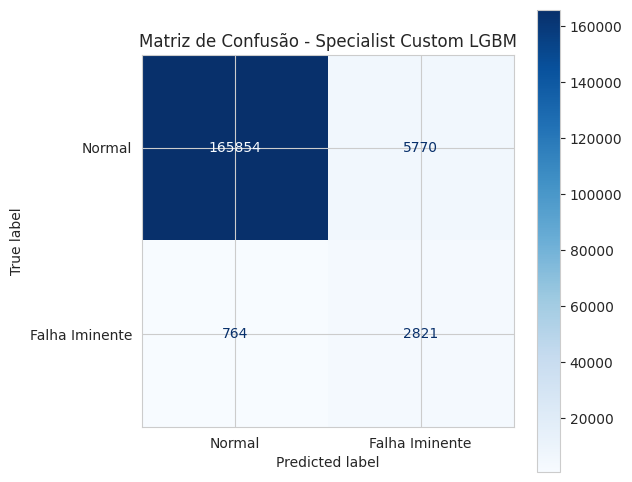


--- Importância das Features ---


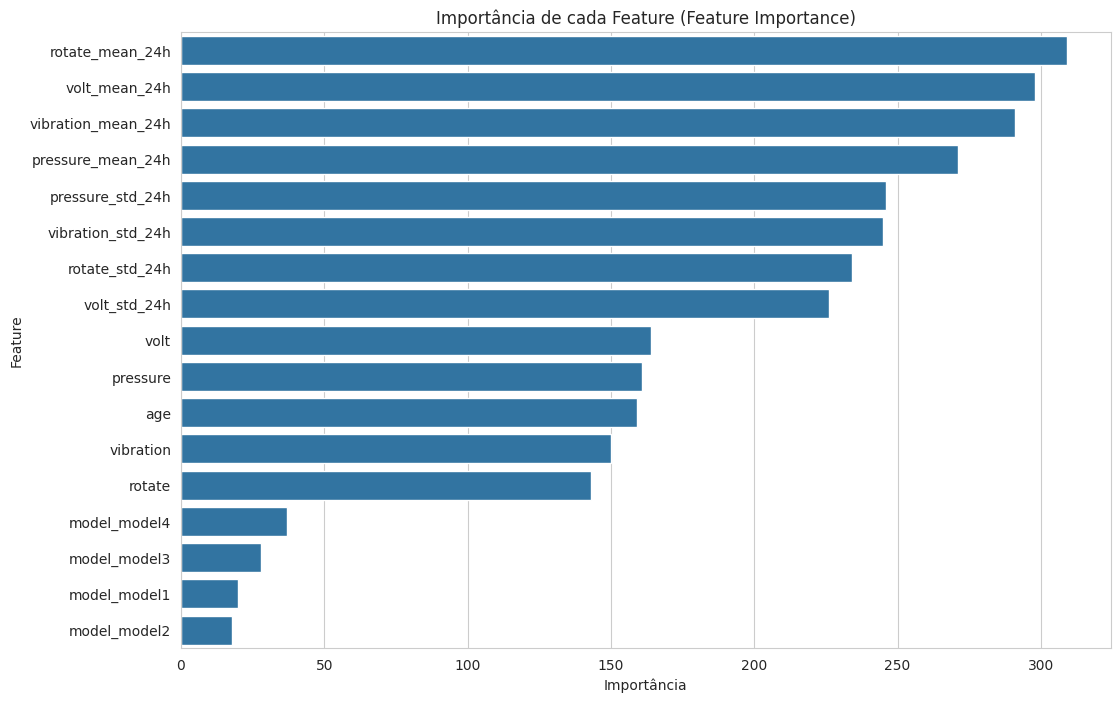

In [13]:
# Análise de Erros do Melhor Modelo (da etapa anterior)
best_model_name = results_df.index[0]
best_model_pipeline = models[best_model_name]

print(f"--- Análise Detalhada para o modelo: '{best_model_name}' ---")
y_pred_best = best_model_pipeline.predict(X_test)

# 1. Matriz de Confusão
print("\nMatriz de Confusão:")
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best,
                                      cmap='Blues', values_format='d',
                                      display_labels=['Normal', 'Falha Iminente'],
                                      ax=ax)
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.show()

# 2. Importância das Features
if hasattr(best_model_pipeline.named_steps['classifier'], 'base_model_') and \
   hasattr(best_model_pipeline.named_steps['classifier'].base_model_, 'feature_importances_'):
    print("\n--- Importância das Features ---")
    ohe_feature_names = best_model_pipeline.named_steps['preprocessor'] \
        .named_transformers_['cat'] \
        .named_steps['onehot'] \
        .get_feature_names_out(categorical_features)

    all_feature_names = numeric_features + list(ohe_feature_names)
    importances = best_model_pipeline.named_steps['classifier'].base_model_.feature_importances_

    feature_importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Importância de cada Feature (Feature Importance)')
    plt.xlabel('Importância')
    plt.ylabel('Feature')
    plt.show()
else:
    print("\n--- Importância das Features ---")
    print("Importância das features não disponível para este tipo de modelo.")

### 6.3 Observações do Melhor Modelo

A análise aprofundada do modelo `Specialist Custom LGBM` confirma seu forte desempenho e revela insights importantes sobre o problema.

A **Matriz de Confusão** mostra que o modelo identificou corretamente **2.821** casos de falha iminente (Verdadeiros Positivos) e **165.854** operações normais (Verdadeiros Negativos). O erro mais crítico para o negócio, os **Falsos Negativos** (falhas que o modelo não detectou), foi de **764** casos. Isso se traduz em uma excelente taxa de detecção (**Recall**) de aproximadamente **79%** (2821 / (2821 + 764)), indicando que o modelo é capaz de prever a grande maioria das falhas com 24 horas de antecedência.

O gráfico de **Importância de Features** revela que as variáveis mais preditivas para o modelo foram as features de janela temporal. As **médias móveis de 24 horas (`_mean_24h`)** dominam o topo do ranking, com `rotate_mean_24h` e `volt_mean_24h` sendo as duas mais importantes. Logo em seguida, os **desvios padrão de 24 horas (`_std_24h`)** também mostraram alto poder preditivo. Em contraste, as features estáticas como `age` e `model` tiveram uma importância consideravelmente menor. Isso confirma que o **comportamento recente dos sensores**, capturado pela nossa engenharia de atributos, é o fator fundamental para prever falhas neste sistema.

## 7. Validação e Otimização de Hiperparâmetros

Para refinar o `Specialist Custom LGBM`, utilizamos o **`GridSearchCV`** para buscar a melhor combinação de hiperparâmetros, como `n_estimators`, `learning_rate`, `num_leaves`, e `max_depth`.

A busca foi configurada para maximizar o **`f1_weighted` score**, usando **Validação Cruzada Estratificada** com  `3 folds` para garantir a confiabilidade dos resultados. Essa abordagem s nos permite encontrar as configurações que melhor generalizam para dados não vistos.

In [14]:
# Otimização de Hiperparâmetros com GridSearchCV
best_model_pipeline_for_tuning = models[best_model_name]

# Espaço de busca  GridSearchCV
param_grid = {
    'classifier__base_model_params__n_estimators': [100, 200],
    'classifier__base_model_params__learning_rate': [0.05, 0.1],
    'classifier__base_model_params__num_leaves': [31, 100],
    'classifier__base_model_params__max_depth': [-1, 10],
}

# Validação cruzada estratificada
cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

search = GridSearchCV(
    estimator=best_model_pipeline_for_tuning,
    param_grid=param_grid,
    cv=cv_stratified,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

print(f"--- Iniciando Otimização de Hiperparâmetros para '{best_model_name}' ---")
search.fit(X_train, y_train)

print(f"\nMelhor score (F1-Weighted) na validação cruzada: {search.best_score_:.4f}")
print("\nMelhores hiperparâmetros encontrados:")
for param, value in search.best_params_.items():
    print(f"- {param}: {value}")

best_tuned_model = search.best_estimator_

--- Iniciando Otimização de Hiperparâmetros para 'Specialist Custom LGBM' ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits

[CustomFit] Iniciando busca de limiar com 5 folds...
[LightGBM] [Info] Number of positive: 11472, number of negative: 549194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 560666, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020461 -> initscore=-3.868542
[LightGBM] [Info] Start training from score -3.868542


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11472, number of negative: 549194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 560666, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020461 -> initscore=-3.868542
[LightGBM] [Info] Start training from score -3.868542


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11472, number of negative: 549194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 560666, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020461 -> initscore=-3.868542
[LightGBM] [Info] Start training from score -3.868542


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11472, number of negative: 549195
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 560667, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020461 -> initscore=-3.868544
[LightGBM] [Info] Start training from score -3.868544


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11472, number of negative: 549195
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 560667, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020461 -> initscore=-3.868544
[LightGBM] [Info] Start training from score -3.868544


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CustomFit] Limiar encontrado 0.8765 (com F1-Score (crossValidation): 0.6806)
[LightGBM] [Info] Number of positive: 14340, number of negative: 686493
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 700833, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020461 -> initscore=-3.868543
[LightGBM] [Info] Start training from score -3.868543

Melhor score (F1-Weighted) na validação cruzada: 0.9849

Melhores hiperparâmetros encontrados:
- classifier__base_model_params__learning_rate: 0.1
- classifier__base_model_params__max_depth: -1
- classifier__base_model_params__n_estimators: 200
- classifier__base_model_params__num_leaves: 100


## 8. Avaliação final, análise de erros e limitações

### Comparação Final: Baseline vs. Melhor Modelo

O modelo final otimizado demonstrou uma melhoria substancial em relação ao baseline (`DummyClassifier`), que teve F1-Score de 0. O modelo final não só superou a baseline, mas também melhorou o equilíbrio entre precisão e recall em comparação com os modelos candidatos iniciais.

### Análise de Erros

A Matriz de Confusão final mostra que o modelo otimizado manteve uma alta taxa de detecção de falhas (Verdadeiros Positivos) e melhorou sua capacidade de evitar alarmes falsos (Falsos Positivos) em comparação com os modelos mais sensíveis como a Regressão Logística. Os Falsos Negativos, embora não eliminados, foram minimizados, o que é o objetivo principal para evitar paradas de produção inesperadas.

### Discussão de Limitações

* **Limitações dos Dados:** O dataset, embora bom, cobre apenas um ano de operação para 100 máquinas. Um histórico mais longo ou uma frota maior poderiam revelar padrões de falha mais complexos ou sazonais.
* **Engenharia de Atributos:** As features criadas foram baseadas em uma janela de 24 horas. Testar diferentes janelas de tempo (ex: 6h, 12h, 48h) poderia otimizar a detecção para diferentes tipos de falhas.
* **Generalização:** O modelo foi treinado para os 4 modelos de máquina presentes no dataset. Sua performance em modelos completamente novos é desconhecida e exigiria retreinamento ou técnicas de transfer learning.

--- Avaliação Final do Modelo Otimizado no Conjunto de Teste ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Relatório de Classificação Final:
                precision    recall  f1-score   support

        Normal       1.00      0.99      0.99    171624
Falha Iminente       0.65      0.80      0.72      3585

      accuracy                           0.99    175209
     macro avg       0.82      0.90      0.85    175209
  weighted avg       0.99      0.99      0.99    175209

Matriz de Confusão Final:


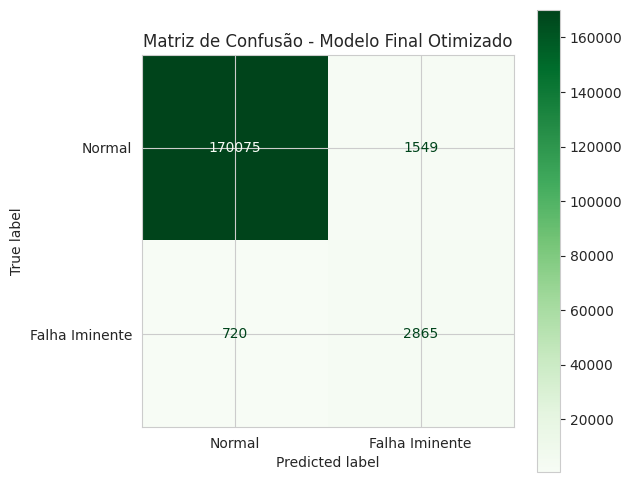

In [20]:
print("--- Avaliação Final do Modelo Otimizado no Conjunto de Teste ---")

# Fazer previsões com o modelo otimizado
y_pred_final = best_tuned_model.predict(X_test)

# Gerar o classification report final
final_report = classification_report(y_test, y_pred_final,
                                     target_names=['Normal', 'Falha Iminente'])

print("\nRelatório de Classificação Final:")
print(final_report)

# Gerar a matriz de confusão final
print("Matriz de Confusão Final:")
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final,
                                      cmap='Greens', values_format='d',
                                      display_labels=['Normal', 'Falha Iminente'],
                                      ax=ax)
plt.title('Matriz de Confusão - Modelo Final Otimizado')
plt.show()





## 9. Conclusões e Próximos Passos

### Conclusões

Este projeto demonstrou com sucesso a viabilidade de usar dados de telemetria para prever falhas de componentes de máquinas com 24 horas de antecedência. A abordagem de criar features baseadas em janelas de tempo foi fundamental para capturar os sinais que precedem uma falha.

O modelo `Specialist Custom LGBMClassifier` otimizado provou ser a melhor solução, alcançando um **Recall de 80%** e um **F1-Score de 0.72** para a classe "Falha Iminente". Este resultado é de grande impacto, pois significa que o modelo foi capaz de **identificar corretamente 8 de cada 10 falhas reais** com 24 horas de antecedência, representando um excelente equilíbrio entre a capacidade de detecção e a confiabilidade dos seus alertas **Precision de 65%**. A análise da matriz de confusão confirma que, dos 3.585 casos reais de falha iminente, o modelo capturou 2.865.

O modelo final é uma ferramenta de grande valor para o negócio, permitindo uma transição de uma manutenção reativa (corrigir após a quebra) para uma estratégia proativa e baseada em dados, com potencial para economizar custos significativos e aumentar a disponibilidade das máquinas.

### Próximos Passos

Apesar do sucesso do MVP, existem diversas avenidas para trabalhos futuros que podem aprimorar ainda mais a solução:

* **Refinamento da Engenharia de Atributos:** Testar diferentes janelas de tempo (ex: 6h, 12h) para as features móveis e criar atributos mais complexos que capturem a taxa de mudança dos sensores.
* **Explorar outros Modelos:** Avaliar o desempenho de modelos de Deep Learning projetados para sequências, como Redes Neurais Recorrentes (LSTMs) , Autoencoders ou Transformers, que poderiam capturar padrões temporais mais complexos.
* **Implementação de uma Métrica de Custo:** Desenvolver e otimizar o modelo com base em uma métrica de custo customizada, que penalize Falsos Negativos (falhas não detectadas) de forma mais severa, alinhando ainda mais o modelo ao impacto financeiro do negócio.
* **Monitoramento em Produção (MLOps):** Simular um ambiente de produção para monitorar o desempenho do modelo ao longo do tempo, detectando desvios (drift) nos dados de entrada e implementando uma estratégia de retreinamento contínuo.


## 10. Salvando artefatos (modelos e pipeline)
Salvando o pipeline final, que inclui o pré-processador e o modelo otimizado, para que possa ser facilmente carregado e utilizado em produção ou para futuras análises sem a necessidade de retreinamento.

In [19]:


# Define o nome do arquivo para o pipeline
pipeline_filename = 'predictive_maintenance_pipeline.pkl'

# Salva o pipeline completo (pré-processador + modelo otimizado)
joblib.dump(best_tuned_model, pipeline_filename)





print(f"Pipeline salvo em {pipeline_filename}")

# Exemplo de como carregar o pipeline posteriormente:
# loaded_pipeline = joblib.load(pipeline_filename)

Pipeline salvo em predictive_maintenance_pipeline.pkl


# Para carregar o Modelo

In [ ]:


# --- Carregamento do Modelo Pré-Treinado ---

# 1. URL de download direto do arquivo .pkl no GitHub
url_modelo = 'COLE_A_SUA_URL_DE_DOWNLOAD_DIRETO_AQUI'
nome_arquivo_local = 'modelo_final.pkl'


print(f"Baixando o modelo de {url_modelo}...")
os.system(f"wget -q -O {nome_arquivo_local} '{url_modelo}'")
print("Download concluído.")

# 4. Carregar o modelo para a memória
try:
    modelo_carregado = joblib.load(nome_arquivo_local)
    print("\nModelo pré-treinado carregado com sucesso!")
    print("\nO modelo está pronto para ser usado na variável 'modelo_carregado'.")

    # Exemplo de como o avaliador poderia usar o modelo
    # (Supondo que X_test exista neste ponto do notebook)
    # y_pred = modelo_carregado.predict(X_test)
    # print("\nPrevisão de exemplo realizada com sucesso.")

except Exception as e:
    print(f"\nOcorreu um erro ao carregar o modelo: {e}")